# Learning Uncertainty Sets

In [149]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

In [150]:
def pareto_frontier(Xs, Ys, maxX = False, maxY = False):
    Xs = np.array(Xs)
    Ys = np.array(Ys)
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
        if maxY: 
            if pair[1] >= p_front[-1][1]: # Look for higher values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
        else:
            if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

### Example 1: Intro example, max of affine uncertainty
We consider a problem with max of affine uncertainty, 

$$g(u,x) = \max_{l=1,\dots,L} (P_lu + a_l)^Tx,$$
where $P_l$ and $a_l$ are constants for all $l = 1, \dots, L$. The robust formulation is 
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & \max_{l=1,\dots,L} (P_lu + a_l)^Tx  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& x \geq 0,
\end{array}
$$


where $\theta$ encodes the training parameters $(A,b)$.

We formulate the Newsvendor problem with this framework, where we solve
\begin{equation}
	\begin{array}{ll}
		\text{minimize} & \tau\\
		\text{subject to} & k^Tx  + \max\{-p^Tx,- p^Tu\} \le \tau \quad \forall u \in \mathcal{U}(\theta) \\
		& x \geq 0.
	\end{array}
\end{equation}

In [151]:
# Formulate constants
n = 2
N = 50
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([4.,5.])
p = np.array([5,6.5])
k_tch = torch.tensor(k, requires_grad = True)
p_tch = torch.tensor(p, requires_grad = True)

def loss(t,x,alpha,data, mu = 1, l = 5, quantile = 0.95,target = 1.): 
    sums = torch.mean(torch.maximum(
        torch.maximum( k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)) - t - alpha, 
        torch.tensor(0.,requires_grad = True)))
    sums = sums/(1-quantile) + alpha
    return t + l*(sums - target) + (mu/2)*(sums - target)**2, t, torch.mean((torch.maximum(
        torch.maximum(k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)) - t, 
        torch.tensor(0.,requires_grad = True))>=0.001).float()), sums.detach().numpy()

def gen_demand_intro(N, seed):
    np.random.seed(seed)
    sig = np.array([[0.6,-0.2],[-0.2,0.1]])
    mu = np.array((1,0.7))
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train


# Generate data
data = gen_demand_intro(N, seed=5)

In [152]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
# y = cp.Variable()

objective = cp.Minimize(t)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [x_r >= 0]

prob = lropt.RobustProblem(objective, constraints)
target = -0.
s = 13

# setup intial A, b
train, test = train_test_split(data, test_size=int(data.shape[0]*0.2), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)

# Train A and b
result1 = prob.train(lr = 0.001, step=100, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_mu = 1, init_lam = 5, target_cvar = target, init_alpha = -0.1, save_iters= True)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b
A1_iters, b1_iters = result1.uncset_iters

result2 = prob.train(eps = True, lr = 0.001, step= 100, momentum = 0.8, optimizer = "SGD", seed = s, init_A = A_fin, init_b = b_fin, init_mu = 1, init_lam = 5, target_cvar = target, init_alpha = -0.1)
df_r1 = result2.df

result3 = prob.train(eps = True, lr = 0.001, step=100, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 1, init_lam = 5,  target_cvar = target, init_alpha  =-0.1)
df_r2 = result3.df

# Grid search standard
result4 = prob.grid(epslst = np.linspace(0.01, 2.98, 40), init_A = result3.A, init_b = result3.b, seed = s, init_alpha = -0.)
dfgrid = result4.df

# Grid search reshaped
result5 = prob.grid(epslst = np.linspace(0.01, 2.98, 40), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = -0.)
dfgrid2 = result5.df

### GIF

In [5]:
def final_solve(A_final, b_final):

    n = 2
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Ellipsoidal(p=2,
                                                        A = A_final, b = b_final))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    t = cp.Variable()

    objective = cp.Minimize(t)

    constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
    constraints += [x_r >= 0]

    prob = lropt.RobustProblem(objective, constraints)
    prob.solve()
    # result3.reform_problem.solve()
    x_final = x_r.value
    t_final = t.value

    return x_final, t_final


x_opt_learned, t_opt_learned = final_solve(A_fin, b_fin)
x_opt_base, t_opt_base = final_solve(init, init_bval)



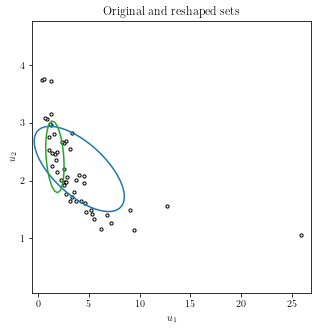

In [6]:
# Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
offset = 1
x_min, x_max = np.min(data[:,0]) - offset, np.max(data[:,0]) + offset
y_min, y_max = np.min(data[:,1]) - offset, np.max(data[:,1]) + offset
n_points = 100
X = np.linspace(x_min,x_max,n_points)
Y = np.linspace(y_min,y_max,n_points)
x_mesh,y_mesh = np.meshgrid(X,Y)

def level_set(A_final, b_final, offset = 2, n = n_points, x_mesh = x_mesh, y_mesh = y_mesh):
    x_opt, t_opt = final_solve(A_final, b_final)
    unc_level_set = np.zeros((n,n))
    g_level_set = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            u_vec = [x_mesh[i,j], y_mesh[i,j]]
            unc_level_set[i,j] = np.linalg.norm(A_final @ u_vec  + b_final)
            g_level_set[i,j] = np.maximum(k @ x_opt - p @ x_opt, k @ x_opt - p @ u_vec) - t_opt

    return unc_level_set, g_level_set


unc_level_learned, g_level_learned = level_set(A_fin, b_fin)
unc_level_base, g_level_base = level_set(init, init_bval)



plt.figure(figsize=(5, 5))
plt.title("Original and reshaped sets")
# Set axis label for the contour plot
plt.xlabel(r"$u_1$")
plt.ylabel(r"$u_2$")

plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "Initial Set")
plt.contour(x_mesh,y_mesh,unc_level_learned, [1], colors = ["tab:green"], label = "Final Set")

plt.scatter(data[:,0],data[:,1], color = "white",edgecolors= "black", s = 10)
# plt.savefig("Reshaped_ctrs.pdf", bbox_inches='tight')
plt.show()


In [7]:
import os
import imageio

filenames = []
for i in range(len(A1_iters)):
    unc_level, g_level = level_set(A1_iters[i], b1_iters[i])
    plt.figure(figsize=(5, 5))
    plt.title("Original and reshaped sets")
    # Set axis label for the contour plot
    plt.xlabel(r"$u_1$")
    plt.ylabel(r"$u_2$")

    plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "Initial Set")
    plt.contour(x_mesh,y_mesh,unc_level, [1], colors = ["tab:red"], label = "trained Set")
    plt.contour(x_mesh,y_mesh,unc_level_learned, [1], colors = ["tab:green"], label = "Final Set")

    filename = f'gif_images/{i}.png'
    filenames.append(filename)

    plt.scatter(data[:,0],data[:,1], color = "white",edgecolors= "black", s = 10)
    plt.savefig(filename)
    plt.close()

    

In [8]:
with imageio.get_writer('gifs/intro.gif', mode='I') as writer:
    for i, filename in enumerate(filenames):
        if i < 50:
            image = imageio.imread(filename)
            writer.append_data(image)

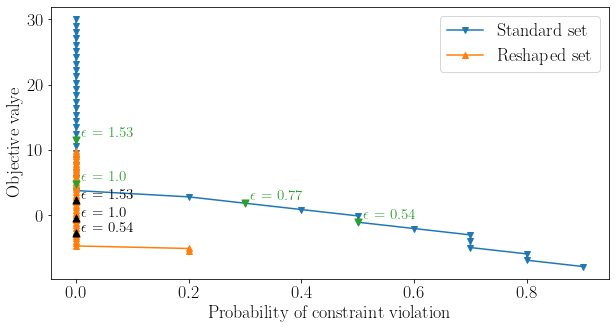

In [153]:
eps_list = np.linspace(0.01, 2.98, 40)
inds = [20,13,10,7]

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
# ax1.plot((df_r2['A_norm']), df_r2['Violations'], color="tab:blue", label=r"Original set")
# ax1.plot((df_r1['A_norm']), df_r1['Violations'], color="tab:orange", label="Reshaped set")
# # ax1.set_yscale("log")
# ax1.set_xlabel("Size parameter $\epsilon$")
# ax1.set_ylabel("Value of constraint violation")
plt.figure(figsize=(10, 5))
plt.plot(dfgrid['Violations'][:], dfgrid['Test_val'][:], color="tab:blue", label=r"Standard set", marker = "v",zorder=0)
for ind in range(4):
    plt.scatter(dfgrid['Violations'][inds[ind]],dfgrid['Test_val'][inds[ind]], color="tab:green", s = 50, marker = "v",zorder= 10)
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds[ind]],2)), # this is the text
                  (dfgrid['Violations'][inds[ind]],dfgrid['Test_val'][inds[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,3), # distance from text to points (x,y)
                  ha='left',color="tab:green",fontsize=15) 

plt.plot(dfgrid2['Violations'],dfgrid2['Test_val'], color="tab:orange", label="Reshaped set", marker = "^",zorder=1)
for ind in [0,1,3]:
    plt.scatter(dfgrid2['Violations'][inds[ind]],dfgrid2['Test_val'][inds[ind]], color="black", s = 50, marker = "^")
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds[ind]],2)), # this is the text
                  (dfgrid2['Violations'][inds[ind]],dfgrid2['Test_val'][inds[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,1), # distance from text to points (x,y)
                  ha='left',color="black", fontsize = 15) 
plt.ylabel("Objective valye")
# ax2.set_xlim([-1,20])
plt.xlabel("Probability of constraint violation")
plt.legend()
# lgd = plt.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_curves1.pdf", bbox_inches='tight')
# plt.savefig("ex1_curves1.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


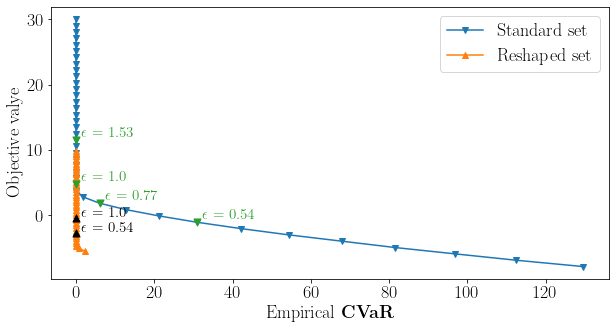

In [154]:
eps_list = np.linspace(0.01, 2.98, 40)
inds = [20,13,10,7]

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
# ax1.plot((df_r2['A_norm']), df_r2['Violations'], color="tab:blue", label=r"Original set")
# ax1.plot((df_r1['A_norm']), df_r1['Violations'], color="tab:orange", label="Reshaped set")
# # ax1.set_yscale("log")
# ax1.set_xlabel("Size parameter $\epsilon$")
# ax1.set_ylabel("Value of constraint violation")
plt.figure(figsize=(10, 5))
plt.plot(dfgrid['Violation_val'][:], dfgrid['Test_val'][:], color="tab:blue", label=r"Standard set", marker = "v",zorder=0)
for ind in range(4):
    plt.scatter(dfgrid['Violation_val'][inds[ind]],dfgrid['Test_val'][inds[ind]], color="tab:green", s = 50, marker = "v",zorder= 10)
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds[ind]],2)), # this is the text
                  (dfgrid['Violation_val'][inds[ind]],dfgrid['Test_val'][inds[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,3), # distance from text to points (x,y)
                  ha='left',color="tab:green",fontsize=15) 

plt.plot(dfgrid2['Violation_val'],dfgrid2['Test_val'], color="tab:orange", label="Reshaped set", marker = "^",zorder=1)
for ind in [1,3]:
    plt.scatter(dfgrid2['Violation_val'][inds[ind]],dfgrid2['Test_val'][inds[ind]], color="black", s = 50, marker = "^")
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds[ind]],2)), # this is the text
                  (dfgrid2['Violation_val'][inds[ind]],dfgrid2['Test_val'][inds[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,1), # distance from text to points (x,y)
                  ha='left',color="black", fontsize = 15) 
plt.ylabel("Objective valye")
# ax2.set_xlim([-1,20])
plt.xlabel("Empirical $\mathbf{CVaR}$")
plt.legend()
# lgd = plt.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_cvar.pdf", bbox_inches='tight')
# plt.savefig("ex1_curves1.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


In [155]:
x_opt_base = {}
x_opt_base1 = {}
x_opt_learned = {}
x_opt_learned1 = {}
t_learned = {}
t_base = {}
for ind in range(4):
    n = 2
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Ellipsoidal(p=2,
                                                        A = (1/eps_list[inds[ind]])*result3.A, b = (1/eps_list[inds[ind]])*result3.b))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    t = cp.Variable()
    # y = cp.Variable()

    objective = cp.Minimize(t)

    constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
    # constraints += [cp.maximum(k1@(x_r-u),0) <= y]
    # constraints = [cp.maximum(u@k + k1@x_r -u@(k + k1), u@k + k1@x_r - x_r@(k + k1))<=t]

    constraints += [x_r >= 0]

    prob = lropt.RobustProblem(objective, constraints)
    prob.solve()
    # result3.reform_problem.solve()
    x_opt_base[ind] = x_r.value

    t_base[ind] = t.value

    n = 2
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Ellipsoidal(p=2,
                                                        A = (1/eps_list[inds[ind]])*A_fin, b = (1/eps_list[inds[ind]])*b_fin))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    t = cp.Variable()
    # y = cp.Variable()

    objective = cp.Minimize(t)

    constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
    # constraints += [cp.maximum(k1@(x_r-u),0) <= y]
    # constraints = [cp.maximum(u@k + k1@x_r -u@(k + k1), u@k + k1@x_r - x_r@(k + k1))<=t]

    constraints += [x_r >= 0]

    prob = lropt.RobustProblem(objective, constraints)
    prob.solve()
    # result3.reform_problem.solve()
    x_opt_learned[ind] = x_r.value

    t_learned[ind] = t.value
    x_opt_learned,x_opt_base,t_learned, t_base
    # A_fin, init, b_fin, init_bval
# x_opt_learned,x_opt_base,t_learned, t_base
A_fin, b_fin, init, init_bval

(array([[ 1.08291468, -0.12898912],
        [ 0.39729256,  1.67069628]]),
 array([-1.49028063, -4.687229  ]),
 array([[0.24262694, 0.17129025],
        [0.17129025, 1.78301619]]),
 array([-1.36187617, -4.61941386]))

<Figure size 360x360 with 0 Axes>

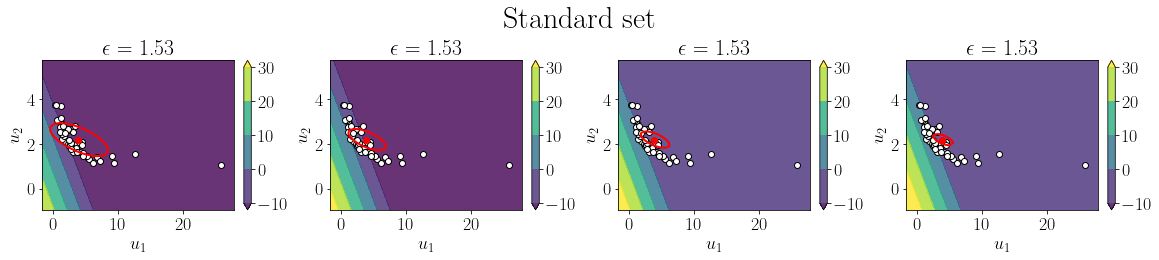

In [156]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"
K =1
plt.figure(figsize=(5, 5))
num_p = 50
offset = 2
x_min, x_max = np.min(data[:,0]) - offset, np.max(data[:,0]) + offset
y_min, y_max = np.min(data[:,1]) - offset, np.max(data[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(4):
# init_set = np.zeros((num_p,num_p))
    g_level_learned[ind] = np.zeros((num_p,num_p))
    g_level_base[ind] = np.zeros((num_p,num_p))
    # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/eps_list[inds[ind]])*b_fin)

            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*result3.A[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  + (1/eps_list[inds[ind]])*result3.b)
            g_level_learned[ind][i,j] = np.maximum(k @ x_opt_learned[ind] - p @ x_opt_learned[ind], k @ x_opt_learned[ind] - p @ u_vec) - t_learned[ind]
            g_level_base[ind][i,j] = np.maximum(k @ x_opt_base[ind] - p @ x_opt_base[ind], k @ x_opt_base[ind] - p @ u_vec) - t_base[ind]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
ax_lst = [ax1, ax2, ax3, ax4]

cur_ind = 0
contours = []
for axis in ax_lst:
    axis.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[cur_ind]],2)))
    axis.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[0]],2)))
    axis.set_xlabel(r"$u_1$")
    axis.set_ylabel(r"$u_2$")
    for k_ind in range(K):
        axis.contour(x,y,init_set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
    a1 = axis.contourf(x,y,g_level_base[cur_ind],np.arange(-10, 40, 10),extend='both',alpha = 0.8)
    contours.append(a1)
    axis.scatter(data[:,0],data[:,1], color = "white" ,edgecolors= "black")
    axis.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1],color = ["red"])
    fig.colorbar(contours[-1], ax = axis)
    cur_ind +=1

fig.suptitle("Standard set", fontsize = 30)

plt.savefig("Reshaped1_cons.pdf", bbox_inches='tight')


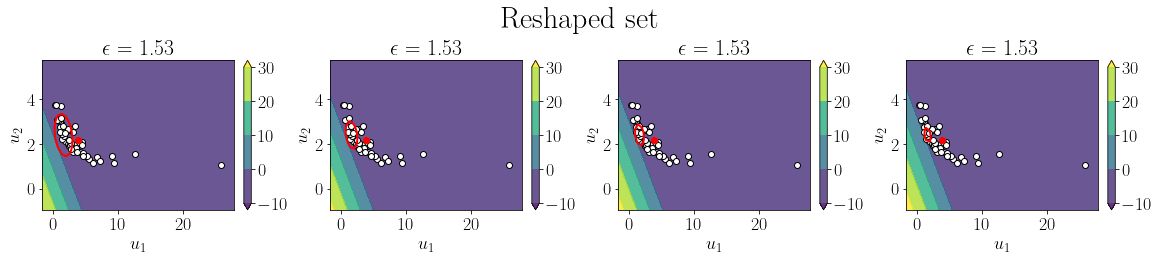

In [158]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
ax_lst = [ax1, ax2, ax3, ax4]
cur_ind = 0
contours = []
for axis in ax_lst:
    axis.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[cur_ind]],2)))
    axis.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[0]],2)))
    axis.set_xlabel(r"$u_1$")
    axis.set_ylabel(r"$u_2$")
    for k_ind in range(K):
        axis.contour(x,y,fin_set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
    a1 = axis.contourf(x,y,g_level_learned[cur_ind],np.arange(-10, 40, 10),extend='both',alpha = 0.8)
    contours.append(a1)
    axis.scatter(data[:,0],data[:,1], color = "white" ,edgecolors= "black")
    axis.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1],color = ["red"])
    fig.colorbar(contours[-1], ax = axis)
    cur_ind +=1
fig.suptitle("Reshaped set", fontsize = 30)

plt.savefig("Reshaped2_cons.pdf", bbox_inches='tight')


### Example 2: Larger newsvendor problem
We now consider a larger Newsvendor problem, with two sets of products. 
The robust problem is 
\begin{equation*}
	\begin{array}{ll}
		\text{minimize} & \tau + y\\
		\text{subject to} & k_1^Tx_1 - p_1^T\min\{x_1, u\} \le \tau \quad \forall u \in \mathcal{U}(\theta) \\
		& k_2^Tx_2 - p_2^T\min\{x_2, u\} \le y \quad \forall u \in \mathcal{U}(\theta) \\
		& x_1 \geq x_2 \geq 0.
	\end{array}
\end{equation*}

In [121]:
# Formulate constants
n = 15
N = 300
np.random.seed(399)
k = npr.uniform(2,5,n)
p = k + npr.uniform(0.5,2,n)
k1 = npr.uniform(1,3,n)
p1 = k1 + npr.uniform(0,2,n)
k_tch = torch.tensor(k, requires_grad = True)
p_tch = torch.tensor(p, requires_grad = True)
k1_tch = torch.tensor(k1, requires_grad = True)
p1_tch = torch.tensor(p1, requires_grad = True)

def loss(t,y,x, x1, alpha, data, mu = 100, l=1000, quantile = 0.95, target = 0.):
    sums =  torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t-alpha, 
        torch.tensor(0.,requires_grad = True)))+ torch.mean(torch.maximum(
        torch.maximum(k1_tch@x1 -data@p1_tch, k1_tch@x1 - p1_tch@x) - y-alpha, 
        torch.tensor(0.,requires_grad = True)))
    sums = sums/(2*(1-quantile)) + alpha
    return t +y + l*(sums - target) + (mu/2)*(sums - target)**2, t+y, 0.5*torch.mean((torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True))>=0.001).float()) + 0.5*torch.mean((torch.maximum(
        torch.maximum(k1_tch@x1 -data@p1_tch, k1_tch@x1 - p1_tch@x) - y, 
        torch.tensor(0.,requires_grad = True))>=0.001).float()), sums.detach().numpy()

def gen_demand(n, N, seed=399):
    np.random.seed(seed)
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(-0.2,2,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# Generate data
data = gen_demand(n,N*2)

In [146]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()

objective = cp.Minimize(t+y)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

constraints += [x_r >= 0, x_r >= x_1]

prob = lropt.RobustProblem(objective, constraints)
target = 0.
test_p = 0.5
s = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)
# Train A and b
result1 = prob.train(lr = 0.00001, step=800, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_mu = 5, init_lam = 10, target_cvar = target, init_alpha = 0., mu_multiplier = 1.01, test_percentage = test_p )
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result3 = prob.train(eps = True, lr = 0.00001, step=800, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 5, init_lam = 10,  target_cvar = target, init_alpha =0.,mu_multiplier = 1.01,test_percentage = test_p)
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), init_A = result3.A, init_b = result3.b, seed = s, init_alpha = 0.,test_percentage = test_p)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.01, 3, 40), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0.,test_percentage = test_p)
dfgrid2 = result5.df

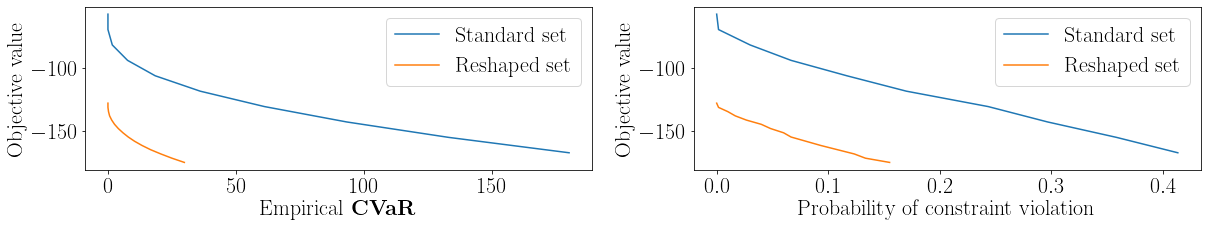

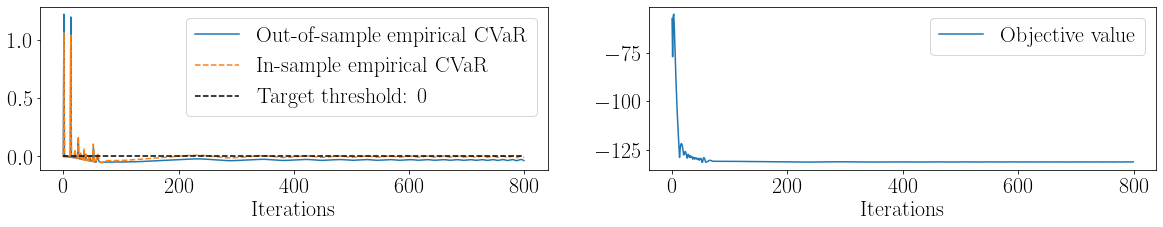

In [147]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":22,
    "font.family": "serif"
})

new = np.array(pareto_frontier(dfgrid2['Violations'][:],dfgrid2['Test_val'][:]))
orig = np.array(pareto_frontier(dfgrid['Violations'][5:],dfgrid['Test_val'][5:]))
orig1 = np.array(pareto_frontier(dfgrid['Violation_val'][5:],dfgrid['Test_val'][5:]))
new1 = np.array(pareto_frontier(dfgrid2['Violation_val'][:],dfgrid2['Test_val'][:]))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
ax1.plot(orig1[0][:], orig1[1][:], color="tab:blue", label=r"Standard set")
ax1.plot(new1[0][:],new1[1][:], color = "tab:orange",label=r"Reshaped set")
ax1.set_xlabel("Empirical $\mathbf{CVaR}$")
ax1.set_ylabel("Objective value")
ax1.legend()

ax2.plot(orig[0][:], orig[1], color="tab:blue", label=r"Standard set")
ax2.plot(new[0][:], new[1][:], color="tab:orange", label=r"Reshaped set")
ax2.set_xlabel("Probability of constraint violation")
ax2.set_ylabel("Objective value")
ax2.legend()
plt.savefig("News_tradeoff_2.pdf",bbox_inches='tight')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
ax1.plot(df1["Violation_val"][:800], label = "Out-of-sample empirical CVaR")
ax1.plot(df1["Violation_train"][:800], label = "In-sample empirical CVaR",linestyle = "--",)
ax1.set_xlabel("Iterations")
ax1.hlines(xmin = 0, xmax = 800, y = -0.0, color = "black", linestyles = "--",label = "Target threshold: 0")
ax1.legend()

ax2.plot(df1["Test_val"][:800], label = "Objective value")
ax2.set_xlabel("Iterations")
ax2.legend()
plt.savefig("News_iters_2.pdf",bbox_inches='tight')

### Example 3: Affine Adjustable Robust Optimization: Inventory management

We solve the robust optimization problem given as 
\begin{equation*}
	\begin{array}{ll}
		\text{minimize} & L\\
		\text{subject to} & -r^Ty^0 - r^TYu + (t+h)^Ts \le L, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
		& y^0_i + y_i^Tu\leq s_i, \quad i = 1, \dots, N, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
		& y^0_i + y_i^Tu \leq d_i^0 + q_i^Tu, \quad i = 1, \dots, N, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
			& \mathbf{1}^Ts = C\\
			& s \leq c\\
			& s \geq 0.
	\end{array}
\end{equation*}


In [18]:
def data_scaled(N, m, scale, seed):
    np.random.seed(seed)
    R = np.vstack([np.random.normal(
        i*0.03*scale, np.sqrt((0.02**2+(i*0.1)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

def data_modes(N, m, scales, seed):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = data_scaled(weights, m, scales[i], seed)
    return d[0:N, :]

def loss(L,y,Y,s,alpha, data,mu=1000,l=10000,quantile = 0.95, target = -0.1):
    sums = 0
    totsum = 0
    Nsample = data.shape[0]
    for i in range(Nsample):
        sums += torch.sum(torch.maximum(y + Y@data[i] - s-alpha, torch.tensor(0.,requires_grad = True)))
        sums += torch.sum(torch.maximum(y + Y@data[i] - torch.tensor(d) - torch.tensor(Q)@data[i] - alpha, torch.tensor(0.,requires_grad = True)))
        sums += torch.maximum(-torch.tensor(r)@y - torch.tensor(r)@Y@data[i] + torch.tensor(t+ h)@s - L - alpha, torch.tensor(0.,requires_grad = True))

        newsums = torch.sum(torch.where(torch.maximum(y + Y@data[i] - s, torch.tensor(0.,requires_grad = True))>=0.001,torch.tensor(1.), torch.tensor(0.)))
        newsums += torch.sum(torch.where(torch.maximum(y + Y@data[i] - torch.tensor(d) - torch.tensor(Q)@data[i], torch.tensor(0.,requires_grad = True))>=0.001,torch.tensor(1.), torch.tensor(0.)))
        newsums += torch.where(torch.maximum(-torch.tensor(r)@y - torch.tensor(r)@Y@data[i] + torch.tensor(t+ h)@s - L, torch.tensor(0.,requires_grad = True))>=0.01, torch.tensor(1.), torch.tensor(0.))
        totsum += newsums/(2*10+1)
    sums = (sums/((1-quantile)*(2*10+1)*Nsample)) + alpha
    return L + torch.tensor(l)*(sums - torch.tensor(target)) + torch.tensor(mu/2)*(sums - torch.tensor(target))**2, L, totsum/Nsample, sums.detach().numpy()

n = 10
m = 4


In [20]:
seed = 26
np.random.seed(seed)
n = 10
m = 4
data = data_modes(600,m,[10,20,30],seed = seed)
# formulate the ellipsoidal set
u = lropt.UncertainParameter(m,
                                uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                  rho=1., data =data, loss =loss))
# formulate cvxpy variable
L = cp.Variable()
s = cp.Variable(n)
y = cp.Variable(n)
Y = cp.Variable((n,m))

# formulate problem constants
C = 2000
c = np.random.uniform(300,500,n)
Q = np.random.uniform(-2,2,(n,m))
d = np.random.uniform(100,200,n)
t = np.random.uniform(1,3,n)
h = np.random.uniform(1,3,n)
r = np.random.uniform(20,40,n)

# formulate objective
objective = cp.Minimize(L)

# formulate constraints
constraints = [-r@y - r@Y@u + (t+h)@s <= L]
for i in range(n):
    constraints += [y[i]+Y[i]@u <= s[i]]
    constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
constraints += [np.ones(n)@s == C]
constraints += [s <=c, s >=0]

# formulate Robust Problem
prob = lropt.RobustProblem(objective, constraints)
target = 0.
# solve
test_p = 0.5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=seed)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)
result1 = prob.train(lr = 0.000001, step=500, momentum = 0.8, optimizer = "SGD", seed = seed, init_A = 0.3*init, init_b = 0.3*init_bval, fixb = False, init_lam = 100, target_cvar = target, init_alpha = -0.05, mu_multiplier = 1.013, test_percentage = test_p)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result3 = prob.train(eps = True, lr = 0.00001, step=500, momentum = 0.8, optimizer = "SGD", seed = seed, init_A = 0.3*init, init_b =0.3*init_bval,  init_lam = 100, target_cvar = target, init_alpha = -0.05, mu_multiplier = 1.013, test_percentage = test_p)
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 1.5, 40), init_A = 0.3*init, init_b = 0.3*init_bval, seed = seed, init_alpha = 0., test_percentage =test_p)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.01,1.5, 40), init_A = A_fin, init_b = b_fin, seed = seed, init_alpha = 0., test_percentage = test_p)
dfgrid2 = result5.df

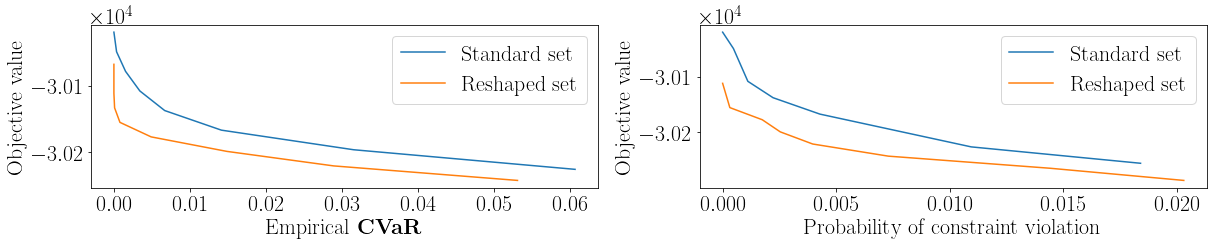

In [21]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":22,
    "font.family": "serif"
})
new_ = np.array(pareto_frontier(dfgrid2['Violations'][:steps],dfgrid2['Test_val'][:steps]))
orig_ = np.array(pareto_frontier(dfgrid['Violations'][:steps],dfgrid['Test_val'][:steps]))
orig2= np.array(pareto_frontier(dfgrid['Violation_val'][:steps],dfgrid['Test_val'][:steps]))
new2 = np.array(pareto_frontier(dfgrid2['Violation_val'][:steps],dfgrid2['Test_val'][:steps]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
ax1.plot(orig2[0][:8], orig2[1][:8], color="tab:blue", label=r"Standard set")
ax1.plot(new2[0][:9],new2[1][:9], color = "tab:orange",label=r"Reshaped set")
ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
ax1.set_xlabel("Empirical $\mathbf{CVaR}$")
ax1.set_ylabel("Objective value")
ax1.legend()

ax2.plot(orig_[0][:9], orig_[1][:9], color="tab:blue", label=r"Standard set")
ax2.plot(new_[0][:9], new_[1][:9], color="tab:orange", label=r"Reshaped set")
ax2.set_xlabel("Probability of constraint violation")
ax2.set_ylabel("Objective value")
ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
ax2.legend()
plt.savefig("Inventory_val_2.pdf",bbox_inches='tight')
plt.show()


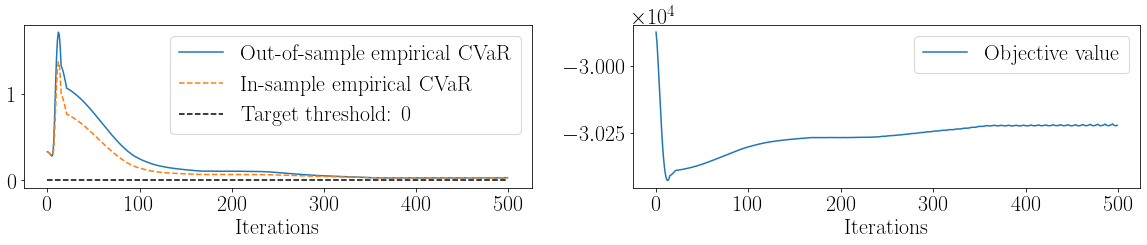

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
steps = 500
ax1.plot(df1["Violation_val"][:steps], label = "Out-of-sample empirical CVaR")
ax1.plot(df1["Violation_train"][:steps], label = "In-sample empirical CVaR",linestyle = "--")

ax1.set_xlabel("Iterations")
ax1.hlines(xmin = 0, xmax = steps, y = -0.0, linestyles = "--",color = "black", label = "Target threshold: 0")
ax1.legend()

ax2.plot(df1["Test_val"][:steps], label = "Objective value")
ax2.set_xlabel("Iterations")
ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)

ax2.legend()
plt.savefig("Inventory_iters.pdf",bbox_inches='tight')